In [1]:
import torch
import torch.nn as nn
import random
from collections import Counter    # 计数类
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np

# 数据集定义

## 原始数据集

### 语音数据集

In [2]:
soundmark = ['ei', 'bi:', 'si:', 'di:', 'i:',  
             'ef', 'dʒi:', 'eit∫', 'ai', 'dʒei', 
             'kei', 'el', 'em', 'en', 'əu', 
             'pi:', 'kju:', 'ɑ:', 'es', 'ti:', 
             'ju:', 'vi:', 'd∧blju:', 'eks', 'wai', 
             'zi:']

### 字母数据集

In [3]:
alphabet = ['a', 'b', 'c', 'd', 'e',
            'f', 'g', 'h', 'i', 'j',
            'k', 'l', 'm', 'n', 'o',
            'p', 'q', 'r', 's', 't',
            'u', 'v', 'w', 'x', 'y',
            'z']

## 序列数据集

In [4]:
t = 10000 # 序列总条数
seq_len = 6  # 序列长度
r = 0.9   # 扰动项
# 原始序列（语音序列），目标序列（字母序列）
src_tokens, tgt_tokens = [], [] 

In [5]:
for i in range(t):
    src, tgt = [], []
    for j in range(seq_len):
        ind = random.randint(0, 25)
        src.append(soundmark[ind])
        if random.random() < r:
            tgt.append(alphabet[ind])
        else:
            tgt.append(alphabet[random.randint(0, 25)])
    src_tokens.append(src)
    tgt_tokens.append(tgt)

### 语音序列数据集

In [6]:
src_tokens[0:5]

[['em', 'em', 'en', 'ai', 'vi:', 'wai'],
 ['vi:', 'ti:', 'zi:', 'eit∫', 'es', 'si:'],
 ['kei', 'dʒi:', 'di:', 'kju:', 'en', 'kju:'],
 ['dʒi:', 'ɑ:', 'bi:', 'ɑ:', 'si:', 'kju:'],
 ['di:', 'i:', 'wai', 'i:', 'em', 'pi:']]

### 字母序列数据集

In [7]:
tgt_tokens[0:5]

[['j', 'm', 'n', 'i', 'v', 'y'],
 ['i', 't', 'z', 'h', 'q', 'c'],
 ['k', 'g', 'd', 'q', 'n', 'q'],
 ['g', 's', 'b', 'r', 'c', 'q'],
 ['d', 'e', 'y', 'u', 'm', 'p']]

## 字典数据集

In [8]:
flatten = lambda li: [item for sublist in li for item in sublist]      # 展平二维数组

In [9]:
class Vocab:
    def __init__(self, tokens):
        self.tokens = tokens  # 传入的tokens是二维列表
        self.token2index = {'<bos>': 0, '<eos>': 1}  # 先存好特殊词元
        # 将token按词频逆序排序后生成token到index字典
        self.token2index.update({
            token: index + 2
            for index, (token, freq) in enumerate(
                sorted(Counter(flatten(self.tokens)).items(), key=lambda x: x[1], reverse=True))
        }) 
        # index到token字典
        self.index2token = {index: token for token, index in self.token2index.items()}
 
    def __getitem__(self, query):
        # 单一索引
        if isinstance(query, (str, int)):
            if isinstance(query, str):
                return self.token2index.get(query, 0)
            elif isinstance(query, (int)):
                return self.index2token.get(query, '<unk>')
        # 数组索引
        elif isinstance(query, (list, tuple)):
            return [self.__getitem__(item) for item in query]
 
    def __len__(self):
        return len(self.index2token)

### 语音字典数据集

In [10]:
# 实例化语音字典数据集
src_vocab = Vocab(src_tokens)

In [11]:
src_vocab[20]

'ti:'

In [12]:
len(src_vocab)

28

### 字母字典数据集

In [13]:
# 实例化字母字典数据集
tgt_vocab = Vocab(tgt_tokens)

In [14]:
tgt_vocab[20]

'v'

In [15]:
len(tgt_vocab)

28

## 序列张量数据集

### 语音序列张量数据集

In [16]:
# 语音序列结尾增加结束标识<eos>，并转换为语音序列张量数据集
src_data = torch.tensor([src_vocab[line + ['<eos>']] for line in src_tokens])

In [17]:
src_data.size()

torch.Size([10000, 7])

### 字母序列张量数据集

In [18]:
# 字母序列结尾增加结束标识<eos>，并转换为字母序列张量数据集
tgt_data = torch.tensor([tgt_vocab[line + ['<eos>']] for line in tgt_tokens])

In [19]:
tgt_data.size()

torch.Size([10000, 7])

## 训练集和测试集

In [20]:
# 训练集和测试集比例8比2
train_size = int(len(src_data) * 0.8)
test_size = len(src_data) - train_size

In [21]:
train_dataset = TensorDataset(src_data[:train_size], tgt_data[:train_size])
test_dataset = TensorDataset(src_data[-test_size:], tgt_data[-test_size:])

In [22]:
batch_size = 16

In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=1)

In [24]:
encoder_input, decoder_target = next(iter(train_loader))

In [25]:
encoder_input.size()  # torch.Size([16, 7])：batch_size和seq_len（即src_data.size()[1]）

torch.Size([16, 7])

# 模型定义

In [26]:
vocab_size = len(src_vocab) # 28
ebd_size = len(src_vocab) # 28
hidden_size = 128
num_layers = 2

## 编码器模块

In [28]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, ebd_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, ebd_size)  # 将字典项（语音或字母）表示为embedding
        self.rnn = nn.RNN(ebd_size, hidden_size, num_layers=num_layers)
 
    def forward(self, encoder_input):
        # encoder_input从(batch_size, seq_len)变成(batch_size, seq_len, ebd_size)
        encoder_input = self.embedding(encoder_input)
        # encoder_input从(batch_size, seq_len, ebd_size)变成(seq_len, batch_size, ebd_size)
        encoder_input = encoder_input.permute(1, 0, 2)
        # output: RNN输出的序列，(seq_len, batch_size, hidden_size)
        # hidden: RNN输出的隐藏状态，(num_layers, batch_size, hidden_size)
        output, hidden = self.rnn(encoder_input)
        return hidden

In [29]:
encoder = Encoder(vocab_size=vocab_size, ebd_size=ebd_size, hidden_size=hidden_size, num_layers=num_layers)

In [30]:
encoder(encoder_input)

tensor([[[ 0.1292,  0.3639,  0.0377,  ...,  0.3189,  0.4545,  0.0670],
         [ 0.3458,  0.4553, -0.1267,  ...,  0.3607,  0.2716, -0.0677],
         [-0.0193,  0.4401,  0.2169,  ...,  0.3692,  0.3610, -0.2553],
         ...,
         [ 0.1998,  0.4283,  0.0101,  ...,  0.3384,  0.2852, -0.0732],
         [ 0.3575,  0.1654,  0.1335,  ...,  0.6270,  0.1248,  0.0163],
         [ 0.2721,  0.3411, -0.2058,  ...,  0.4664,  0.1825,  0.1272]],

        [[ 0.1282,  0.1139, -0.4947,  ...,  0.0155, -0.3880, -0.0642],
         [-0.3080,  0.0375, -0.3650,  ...,  0.3122, -0.2413,  0.0711],
         [ 0.1413,  0.0608, -0.4948,  ...,  0.0909, -0.5764,  0.0345],
         ...,
         [ 0.0705,  0.0323, -0.3737,  ..., -0.0881, -0.2745, -0.0033],
         [ 0.1758,  0.0128, -0.5891,  ...,  0.0275, -0.1932, -0.1739],
         [-0.1475,  0.0371, -0.4316,  ...,  0.1462, -0.2914,  0.0533]]],
       grad_fn=<StackBackward0>)

## 注意力

In [31]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
    def forward(self, Q, K, V):
        '''
        Q: [batch_size, len_q, d_q]  # d_q = d_k
        K: [batch_size, len_k, d_k]
        V: [batch_size, len_v, d_v]  # len_v = len_k
        '''
        d_k = K.size(-1)
        # scores: [batch_size, len_q, len_k]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) 
        # attn: [batch_size, len_q, len_k]
        attn = nn.Softmax(dim=-1)(scores)
        # context: [batch_size, len_q, d_v]
        context = torch.matmul(attn, V) 
        # context: [batch_size, len_q, d_v], attn: [batch_size, len_q, len_k]
        return context, attn

## 解码器模块

In [32]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, ebd_size, hidden_size, num_layers, use_attention):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, ebd_size)
        # 拼接维度ebd_size + hidden_size
        self.rnn = nn.RNN(ebd_size + hidden_size, hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.use_attention = use_attention
 
    def forward(self, decoder_input, encoder_state):
        # 训练时：decoder_input是decoder_target向右偏移一位，左边第一位补<bos>，右边最后一位去掉，序列长度不变
        # 测试时：decoder_input为预测序列中最后一个数据，形状为(batch_size, seq_len) = (1, 1)
        # decoder_input从(batch_size, seq_len)变成(batch_size, seq_len, ebd_size)
        decoder_input = self.embedding(decoder_input)
        # decoder_input从(batch_size, seq_len, ebd_size)变成(seq_len, batch_size, ebd_size)
        decoder_input = decoder_input.permute(1, 0, 2)
        # encoder_state为编码器输出的隐藏状态，size: (num_layers, batch_size, hidden_size)
        # context为编码器输出的最后一层隐藏状态，size: (batch_size, hidden_size)
        context = encoder_state[-1] 
        # context初始形状为(batch_size, hidden_size)，为下一步连接，需repeat为(seq_len, batch_size, hidden_size) 
        context = context.repeat(decoder_input.shape[0], 1, 1)
        # decoder_input从(seq_len, batch_size, ebd_size)变成(seq_len, batch_size, ebd_size + hidden_size)
        decoder_input = torch.cat((decoder_input, context), -1)
        if self.use_attention:
            # 使用注意力
            # context: (seq_len, batch_size, ebd_size + hidden_size) 
            context = nn.Linear(context.size()[-1], decoder_input.size()[-1])(context)
            # decoder_input: (seq_len, batch_size, ebd_size + hidden_size)
            decoder_input, _ = Attention()(decoder_input, context, context)
        # output: RNN输出的序列，(seq_len, batch_size, hidden_size])
        # hidden: RNN输出的隐藏状态，(num_layers, batch_size, hidden_size])
        output, hidden = self.rnn(decoder_input, encoder_state)
        # logits的形状为(seq_len, batch_size, vocab_size)
        logits = self.linear(output)
        return logits, hidden

In [45]:
use_attention = True
decoder = Decoder(vocab_size=vocab_size, ebd_size=ebd_size, hidden_size=hidden_size, num_layers=num_layers, use_attention=use_attention)

## seq2seq类

In [46]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
 
    def forward(self, encoder_input, decoder_input):
        encoder_state = self.encoder(encoder_input)
        return self.decoder(decoder_input, encoder_state)

In [47]:
# 建立模型
model = Seq2Seq(encoder, decoder)

# 模型训练

In [48]:
# 设置超参数
lr = 0.001
num_epochs = 20

In [49]:
# 交叉熵损失及adam优化器
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [50]:
# 记录损失变化
loss_history = []

In [51]:
# 开始训练
model.train()
for epoch in tqdm(range(num_epochs)):
    for encoder_input, decoder_target in train_loader:
        bos_column = torch.tensor([tgt_vocab['<bos>']] * decoder_target.shape[0]).reshape(-1, 1)
        # 训练时：decoder_input是decoder_target向右偏移一位，左边第一位补<bos>，右边最后一位去掉，序列长度不变
        decoder_input = torch.cat((bos_column, decoder_target[:, :-1]), dim=1)
        # pred的形状为(seq_len, batch_size, vocab_size)
        pred, _ = model(encoder_input, decoder_input)
        # decoder_target的形状为 (batch_size, seq_len)，我们需要改变pred的形状以保证它能够正确输入
        # pred的形状变为(batch_size, vocab_size, seq_len)
        pred = pred.permute(1, 2, 0)
        # loss的形状为(batch_size, seq_len)，其中每个元素都代表了一个词元的损失
        loss = criterion(pred, decoder_target).mean()
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:59<00:00, 11.97s/it]


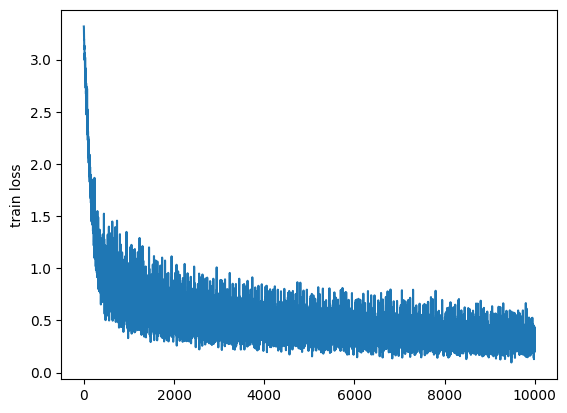

In [52]:
plt.plot(loss_history)
plt.ylabel('train loss')
plt.show()

# 模型测试

In [53]:
model.eval()
translation_results = []
correct = 0
error = 0
# 因为batch_size是1，所以每次取出来的都是单个句子
# 从test_loader中加载源序列和目标序列
for src_seq, tgt_seq in test_loader:
    encoder_input = src_seq
    # encoder_output: (seq_len, batch_size, hidden_size)
    # hidden: (num_layers: 2, batch_size: 16, hidden_size: 128])
    hidden = model.encoder(encoder_input)
    # 初始化预测序列
    pred_seq = [tgt_vocab['<bos>']]
    # 循环预测，一次预测一个数据，不断增加预测序列的长度
    for _ in range(seq_len):
        # 测试时：decoder_input为预测序列中最后一个数据，形状为(batch_size, seq_len) = (1, 1)
        decoder_input = torch.tensor(pred_seq[-1]).reshape(1, 1)
        # pred为新预测的数据，形状为 (seq_len, batch_size, vocab_size) = (1, 1, vocab_size)
        pred, hidden = model.decoder(decoder_input, hidden)
        next_token_index = pred.squeeze().argmax().item()
        if next_token_index == tgt_vocab['<eos>']:
            break
        pred_seq.append(next_token_index)  
    # 去掉开头的<bos>
    pred_seq = tgt_vocab[pred_seq[1:]]
    
    # src_seq的形状为(1, seq_len)，将其转化成seq_len的列表
    src_seq = src_seq.squeeze().tolist()
    # 需要注意在<eos>之前截断
    if src_vocab['<eos>'] in src_seq:
        eos_idx = src_seq.index(src_vocab['<eos>'])
        src_seq = src_vocab[src_seq[:eos_idx]]
    else:
        src_seq = src_vocab[src_seq]
        
    # tgt_seq的形状为(1, seq_len)，将其转化成seq_len的列表
    tgt_seq = tgt_seq.squeeze().tolist()
    # 需要注意在<eos>之前截断
    if tgt_vocab['<eos>'] in tgt_seq:
        eos_idx = tgt_seq.index(tgt_vocab['<eos>'])
        tgt_seq = tgt_vocab[tgt_seq[:eos_idx]]
    else:
        tgt_seq = tgt_vocab[tgt_seq]
        
    translation_results.append(('输入：' + ' '.join(src_seq), '输出：' + ' '.join(tgt_seq), '预测：' + ' '.join(pred_seq)))
    for i in range(len(tgt_seq)):
        if i >= len(pred_seq) or pred_seq[i] != tgt_seq[i]:
            error += 1
        else:
            correct += 1

In [54]:
print(correct / (correct + error))
# 不使用注意力：约0.53
# 使用注意力：约0.83

0.8136666666666666


In [55]:
translation_results[-10:]

[('输入：vi: ɑ: dʒei dʒi: ɑ: d∧blju:', '输出：v r j w r w', '预测：v r j g r w'),
 ('输入：ju: zi: ai ef i: ai', '输出：u z i f e i', '预测：u z i f e h'),
 ('输入：vi: ɑ: zi: i: kei kei', '输出：v r z e k k', '预测：v r z e k k'),
 ('输入：eks d∧blju: ai wai ti: ef', '输出：x w i y t f', '预测：x w q y e f'),
 ('输入：eit∫ ai d∧blju: vi: em zi:', '输出：h i w v m z', '预测：h u w v q z'),
 ('输入：en bi: zi: dʒei es bi:', '输出：m b z j s b', '预测：n b z j s b'),
 ('输入：d∧blju: el dʒi: ai eit∫ pi:', '输出：w l g i z p', '预测：w l l i h p'),
 ('输入：si: ti: en i: el dʒei', '输出：c t n e l j', '预测：c t n e l j'),
 ('输入：si: eit∫ əu es zi: dʒi:', '输出：c h o s z g', '预测：m g o s z l'),
 ('输入：ti: əu dʒi: kei dʒi: eks', '输出：t o g k g x', '预测：t o g k g x')]